# Enviornment Setup

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
%matplotlib inline

In [ ]:
#ls youtube_videos

In [ ]:
pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/experiments/

/content/drive/MyDrive/experiments


In [ ]:
ls

AI_project_facenet.ipynb         youtube_faces.ipynb
contrastive_model_200epochs.png  youtube_faces_with_keypoints_full_1/
data/                            youtube_faces_with_keypoints_full_2/
epoch_losses.npy                 youtube_faces_with_keypoints_full_3/
epoch_losses_posonly_2k.npy      youtube_faces_with_keypoints_full_4/
images/                          youtube_faces_with_keypoints_full.csv
kaggle.json                      youtube_labels.json
model_constrast.pt               youtube_num_vids.json
model_posonly_2k.pt              youtube_vecs_noMTCNN.pickle
model.pt                         youtube_vecs.pickle
proj.ipynb                       youtube_video_ids.json


# Get Data

In [ ]:
 mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
ls

data/  kaggle/  kaggle.json  proj.ipynb  youtube_faces.ipynb


In [ ]:
cp kaggle.json ~/.kaggle/

In [ ]:
ls ~/.kaggle

kaggle.json


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d selfishgene/youtube-faces-with-facial-keypoints

100% 16.2G/16.2G [05:36<00:00, 47.4MB/s]
100% 16.2G/16.2G [05:36<00:00, 51.7MB/s]


In [ ]:
!unzip youtube-faces-with-facial-keypoints.zip

Archive:  youtube-faces-with-facial-keypoints.zip
  inflating: youtube_faces_with_keypoints_full.csv  
  inflating: youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/AJ_Cook_0.npz  
  inflating: youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/AJ_Cook_2.npz  
  inflating: youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/Aaron_Eckhart_0.npz  
  inflating: youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/Aaron_Eckhart_1.npz  
  inflating: youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/Abba_Eban_0.npz  
  inflating: youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/Abba_Eban_5.npz  
  inflating: youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/Abdel_Aziz_Al-Hakim_0.npz  
  inflating: youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/Abdel_Aziz_Al-Hakim_1.npz  
  inflating: youtube_faces_with_keypoints_full_1/

# EDA

In [ ]:
data_dir = "./"

In [ ]:
face_keypoints_df = pd.read_csv(os.path.join(data_dir, "youtube_faces_with_keypoints_full.csv"))

In [ ]:
face_keypoints_df.head()

,videoID,personName,imageHeight,imageWidth,videoDuration,averageFaceSize,numVideosForPerson
0,Alison_Lohman_0,Alison_Lohman,228.0,213.0,240.0,90.150000,6.0
1,Alison_Lohman_1,Alison_Lohman,248.0,201.0,79.0,108.417722,6.0
2,Alison_Lohman_2,Alison_Lohman,335.0,308.0,136.0,122.161765,6.0
3,Alison_Lohman_3,Alison_Lohman,151.0,110.0,53.0,58.000000,6.0
4,Alison_Lohman_4,Alison_Lohman,236.0,228.0,147.0,91.680272,6.0


In [ ]:
data_batches_fn = [
    "youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1",
    "youtube_faces_with_keypoints_full_2/youtube_faces_with_keypoints_full_2",
    "youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3",
    "youtube_faces_with_keypoints_full_4/youtube_faces_with_keypoints_full_4"
]

batch_paths = [os.path.join(data_dir, batch_fn) for batch_fn in data_batches_fn]

In [ ]:
def read_batch_data(batch_path):
    '''
    read dataset from gdrive

    Parameters:
    ===========
    batch_path: (str) path to the batch data directory

    Returns:
    ===========
    batch_data: loaded data. contain video data in list. Access the 
                image frames by using the "colorImages" key
    batch_fns: label for each videos. Label will be the person that 
                appears in the video
    '''
    batch_fns = os.listdir(batch_path)
    batch_data_path = [os.path.join(batch_path, fn) for fn in batch_fns]
    batch_data = []
    for p in batch_data_path:
        batch_data.append(np.load(p))
    batch_fns = [fn.split(".")[0] for fn in batch_fns]
    return batch_data, batch_fns

In [ ]:
# test reading first batch data
batch1_data, batch_fns = read_batch_data(batch_paths[0])
print(f"lenght of files: {len(batch1_data)}")

print(f"keys of each data point: {batch1_data[0].files}")

# H, W, C, number of frames
print(f'Frame data shape for first video: {batch1_data[0]["colorImages"].shape}')

# testing transpose
print(f'transpose data to shape of (num_frames, H, W, C): {batch1_data[0]["colorImages"].transpose((3, 0, 1, 2)).shape}')
print(f"label of first video: {batch_fns[0]}")

lenght of files: 544
keys of each data point: ['colorImages', 'boundingBox', 'landmarks2D', 'landmarks3D']
Frame data shape for first video: (192, 125, 3, 73)
transpose data to shape of (num_frames, H, W, C): (73, 192, 125, 3)
label of first video: AJ_Cook_0


In [ ]:
# meta_data df
face_keypoints_df[face_keypoints_df["videoID"] == batch_fns[0]]

,videoID,personName,imageHeight,imageWidth,videoDuration,averageFaceSize,numVideosForPerson
1289,AJ_Cook_0,AJ_Cook,192.0,125.0,73.0,54.90411,2.0


In [ ]:
face_keypoints_df.describe()

,imageHeight,imageWidth,videoDuration,averageFaceSize,numVideosForPerson
count,2194.000000,2194.000000,2194.000000,2194.000000,2194.000000
mean,210.290337,195.633546,118.686873,94.887054,2.929809
std,64.514279,67.464967,71.806225,36.811662,0.959554
min,81.000000,74.000000,42.000000,40.220339,2.000000
25%,163.000000,147.000000,59.000000,67.337232,2.000000
50%,203.000000,185.000000,88.000000,87.578507,3.000000
75%,245.000000,234.000000,178.000000,114.550184,4.000000
max,480.000000,494.000000,240.000000,247.862745,6.000000


# Baseline

### Dataset Class

In [ ]:
from PIL import Image

In [ ]:
class YoutubeVideoDataset(torch.utils.data.Dataset):
    '''
    this dataset will load all video frames, labels, and meta data

    data: shape (num_videos, H, W, C, num_frames)
    fns: list of labels
    id2label: dict with key=video_id and value = (label, num_vid)
              num_vid is a number indicating how many videos of same
              label exist in the youtube video dataset
    '''
    def __init__(self, batch_paths, df):
        data = []
        fns = []
        
        for batch_path in batch_paths:
            batch_data, batch_fns = read_batch_data(batch_path)
            data += batch_data
            fns += batch_fns
        self.data = data
        self.fns = fns

        df_videoIds = list(df.videoID)
        df_labels = list(df.personName)
        df_numVideosForPerson = list(df.numVideosForPerson)
        self.id2label = {}
        for id, label, num_vid in zip(df_videoIds, df_labels, df_numVideosForPerson):
            self.id2label[id] = (label, num_vid)
    
    def preprocess(self, frames):
        '''
        takes video frames and perform following image processing steps:
            - transpose original (H, W, C, num_frames) into (num_frames, H, W, C)
            - resize each frame to (160, 160) which is required for MTCNN
            - convert each frame to numpy array of datatype float
        '''
        frames = frames.transpose((3, 0, 1, 2))
        processed_frames = []
        for frame in frames:
            img = Image.fromarray(frame)
            #img = resizeimage.resize_contain(img, [160, 160]) # (160, 160, 4) the added last channel is just white layer
            img = img.resize((160, 160))
            #processed_frames.append(np.asarray(img, dtype="float")[:, :, :3]) # discard the added white layer
            processed_frames.append(np.asarray(img, dtype="float"))
        return np.array(processed_frames, dtype="float")

    def __getitem__(self, idx):
        '''
        return data at index idx.
        frames: processed frames for the video
        fn: video_id for the video
        label: label for the video
        num_vid: number of videos with same label in the dataset
        '''
        frames = self.data[idx]["colorImages"]
        frames = self.preprocess(frames)
        fn = self.fns[idx]
        label, num_vid = self.id2label[fn]
        return frames, fn, label, num_vid
    
    def __len__(self):
        return len(self.data)

In [ ]:
# create dataset object
dataset = YoutubeVideoDataset(batch_paths, face_keypoints_df)

In [ ]:
print(f"number of videos: {len(dataset)}")

number of videos: 2194


In [ ]:
# example data point
frames, fn, label, num_vid = dataset[10]
print(f"fn: {fn}\nlabel: {label}\nnum vid: {num_vid}\nframes (num_frames, H, W, C): {frames.shape}")

fn: Abdoulaye_Wade_1
label: Abdoulaye_Wade
num vid: 2.0
frames (num_frames, H, W, C): (44, 160, 160, 3)


In [ ]:
# create dataload object
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1)

### Generating Frame Embeddings using FaceNet

In [ ]:
pip install -q facenet-pytorch

     |████████████████████████████████| 1.9 MB 4.3 MB/s 


In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1
from tqdm import tqdm
from torch.utils.data import DataLoader
import pickle
import json

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# create a face detection pipeline using MTCNN
mtcnn = MTCNN(device=DEVICE)

# Create an inception resnet (in eval mode)
resnet = InceptionResnetV1(pretrained='vggface2', device=DEVICE).eval()

torch.Size([73, 160, 160, 3])
AJ_Cook_0
AJ_Cook


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).




data shape: torch.Size([73, 160, 160, 3])
mtcnn return len: 73


Text(0.5, 1.0, 'MTCNN result on cropping face from image')

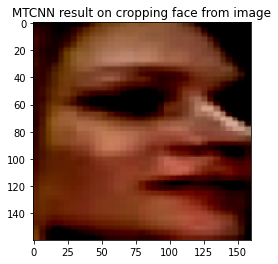

In [ ]:
# inference example for MTCNN
for data in dataloader:
    print(data[0][0].shape)
    print(data[1][0])
    print(data[2][0])
    break
res = mtcnn(data[0][0])
print(f"\n\ndata shape: {data[0][0].shape}")
print(f"mtcnn return len: {len(res)}")
plt.imshow(np.transpose(res[0], (1,2,0)))
plt.title("MTCNN result on cropping face from image")

In [ ]:
# generate image embeddings using mtcnn and facenet
vecs = []
video_ids = []
labels = []
num_vids = []
for batch_data in tqdm(dataloader, total=len(dataloader)):
    # process video by video
    align = mtcnn(batch_data[0][0]) # shape: B, C, 160, 160
    align = [item for item in align if item != None] # remove frames where no face is detected
    vec = resnet(torch.stack(align).to(DEVICE)).detach().cpu() # shape: B, 512

    # store results for the video
    vecs.append(vec)
    video_ids.append(batch_data[1][0])
    labels.append(batch_data[2][0])
    num_vids.append(batch_data[3][0])

  0%|          | 0/2194 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
  0%|          | 7/2194 [00:05<29:44,  1.23it/s]/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

In [ ]:
# uncomment to save the prediction data

"""
with open('youtube_vecs.pickle', 'wb') as f:
    pickle.dump(vecs, f)

with open('youtube_video_ids.json', 'w+') as f:
    json.dump(video_ids, f)

with open('youtube_labels.json', 'w+') as f:
    json.dump(labels, f)

with open('youtube_num_vids.json', 'w+') as f:
    new_num_vids = [num_vid.item() for num_vid in num_vids]
    json.dump(new_num_vids, f)
"""

"\nwith open('youtube_vecs.pickle', 'wb') as f:\n    pickle.dump(vecs, f)\n\nwith open('youtube_video_ids.json', 'w+') as f:\n    json.dump(video_ids, f)\n\nwith open('youtube_labels.json', 'w+') as f:\n    json.dump(labels, f)\n\nwith open('youtube_num_vids.json', 'w+') as f:\n    new_num_vids = [num_vid.item() for num_vid in num_vids]\n    json.dump(new_num_vids, f)\n"

In [ ]:
def load_data():
    '''
    load data
    youtube_vecs.pickle is list of tensors where each tensors contains the frame 
    embedding of a video in shape [num_frames, 512]. youtube_video_ids, youtube_labels, 
    and youtube_num_vids contains the meta information and labels. 
    The order of stored data are the same.
    '''
    vecs = pickle.load(open('youtube_vecs.pickle', "rb"))
    video_ids = json.load(open("youtube_video_ids.json"))
    labels = json.load(open("youtube_labels.json"))
    num_vids = json.load(open("youtube_num_vids.json"))
    return vecs, video_ids, labels, num_vids

In [ ]:
# test load
vecs, video_ids, labels, num_vids = load_data()

In [ ]:
# sanity size check
assert len(vecs) == len(video_ids) == len(labels) == len(num_vids)
print(f"generated vec size for first video (num_frames, 512): {vecs[0].shape}")

generated vec size for first video (num_frames, 512): torch.Size([73, 512])


### Evaluation
 - method: average frame embeddings to create video embedding

In [ ]:
from sklearn.neighbors import NearestNeighbors
import random

In [ ]:
def load_data():
    '''
    load data
    youtube_vecs.pickle is list of tensors where each tensors contains the frame 
    embedding of a video in shape [num_frames, 512]. youtube_video_ids, youtube_labels, 
    and youtube_num_vids contains the meta information and labels. 
    The order of stored data are the same.
    '''
    vecs = pickle.load(open('youtube_vecs.pickle', "rb"))
    video_ids = json.load(open("youtube_video_ids.json"))
    labels = json.load(open("youtube_labels.json"))
    num_vids = json.load(open("youtube_num_vids.json"))
    return vecs, video_ids, labels, num_vids

In [ ]:
vecs, video_ids, labels, num_vids = load_data()
# sanity size check
assert len(vecs) == len(video_ids) == len(labels) == len(num_vids)
print(f"generated vec size for first video (num_frames, 512): {vecs[0].shape}")

generated vec size for first video (num_frames, 512): torch.Size([73, 512])


In [ ]:
# average frame embeddings to create video embedding
# only using first 10 frames to reduce noises of potential 
# outlier frame embedding at the end of the video
video_embeds = [torch.mean(vec[:10], dim=0) for vec in vecs]
video_embeds = torch.vstack(video_embeds)
print(f"shape of video_embeddings: {video_embeds.shape}")

shape of video_embeddings: torch.Size([2194, 512])


In [ ]:
def compute_AP(query_label, neighbor_labels):
    '''
    compute the average precision of the retrieval system
    the highest score will be 1 which happens when all correct
    target is retrieved and ranged higher than other samples
    with different label
    '''
    AP = 0
    true_pos = 0
    for i, label in enumerate(neighbor_labels):
        if label == query_label:
            true_pos += 1
            AP += (true_pos/(i+1))
    
    if true_pos == 0:
        # no video with same label as query video in the dataset
        # exclude this in the calculation of mAP
        return -1

    AP /= true_pos 
    return AP

def knn_eval(video_embeds, labels, query_video_idxes, n_neighbors=None):
    # use knn to rank neighbor videos and compute the mAP

    # train knn
    knn = NearestNeighbors(n_jobs=-1, metric="euclidean", algorithm="brute")
    knn.fit(video_embeds)
    neigh = knn.kneighbors(video_embeds, n_neighbors=n_neighbors, return_distance=False)

    APs = []
    for query_video_idx in query_video_idxes:
        cur_neighs = neigh[query_video_idx] # get neighbor indexes
        cur_neighs = [n_idx for n_idx in cur_neighs if n_idx!=query_video_idx] # remove neighbor that is same video as query
        query_label = labels[query_video_idx] # label for query video
        neighbor_labels = [labels[neigh_idx] for neigh_idx in cur_neighs] # neighbor labels

        AP = compute_AP(query_label, neighbor_labels)
        if AP >= 0:
            APs.append(AP)
    mAP = np.mean(APs)
    
    # print results
    for query_video_idx, AP in zip(query_video_idxes, APs):
        #print(f"Query Video: {query_video_idx} - AP: {AP}")
        break

    print(f"mAP: {mAP}")

In [ ]:
# best performing queries that I manually picked, should give mAP=1
query_video_idxes = [1521, 1724, 840, 1902, 124, 1342, 1925, 1108, 777, 364, 268, 1191, 1554, 2131, 600, 1311, 162, 546, 742, 1410]
knn_eval(video_embeds, labels, query_video_idxes)

mAP: 1.0


In [ ]:
print("mAP for whole dataset with top 20 neighbor retrieval and ranking")
knn_eval(video_embeds, labels, query_video_idxes=list(range(len(video_embeds))), n_neighbors=21)

mAP for whole dataset with top 20 neighbor retrieval
mAP: 0.82454728774587


In [ ]:
print("mAP for whole dataset with whole dataset ranking")
knn_eval(video_embeds, labels, query_video_idxes=list(range(len(video_embeds))), n_neighbors=None)

mAP for whole dataset with whole dataset ranking
mAP: 0.9208663306935445


In [ ]:
def show_query_results(video_embeds, labels, num_vids, query_video_idxes=None):
    '''
    print top 20 retrieval result of the query videos
    '''
    # if no query index given, use 20 random indexes
    if query_video_idxes == None:
        query_video_idxes = random.sample(range(len(labels)), 20)
    
    # train knn
    knn = NearestNeighbors(n_jobs=-1, metric="euclidean", algorithm="brute")
    knn.fit(video_embeds)
    neigh = knn.kneighbors(video_embeds, n_neighbors=21, return_distance=False)

    APs = []
    for query_video_idx in query_video_idxes:
        cur_neighs = neigh[query_video_idx] # get neighbor indexes
        cur_neighs = [n_idx for n_idx in cur_neighs if n_idx!=query_video_idx] # remove neighbor that is same video as query
        query_label = labels[query_video_idx] # label for query video
        neighbor_labels = [labels[neigh_idx] for neigh_idx in cur_neighs] # neighbor labels

        AP = compute_AP(query_label, neighbor_labels)
        if AP >= 0:
            APs.append(AP)

        # print results
        print("="*50)
        print(f"Query Video Index: {query_video_idx}")
        print(f"Query Video Label: {query_label}")
        print(f"Number of Similar Videos in Dataset: {num_vids[query_video_idx]-1}")
        print("-"*25)
        for n_idx in cur_neighs:
            print(f"Targer Video Index: {n_idx} - Label: {labels[n_idx]} - Hit: {labels[n_idx]==query_label}")
        print(f"Average Precision (AP): {AP}")

    mAP = np.mean(APs)
    print(f"\nmAP: {mAP}")

In [ ]:
show_query_results(video_embeds, labels, num_vids)

Query Video Index: 1397
Query Video Label: Marc_Shaiman
Number of Similar Videos in Dataset: 2.0
-------------------------
Targer Video Index: 1399 - Label: Marc_Shaiman - Hit: True
Targer Video Index: 1398 - Label: Marc_Shaiman - Hit: True
Targer Video Index: 607 - Label: Earl_Scruggs - Hit: False
Targer Video Index: 88 - Label: Alexander_Lukashenko - Hit: False
Targer Video Index: 904 - Label: George_Galloway - Hit: False
Targer Video Index: 571 - Label: Daniel_Kurtzer - Hit: False
Targer Video Index: 1490 - Label: Massoud_Barzani - Hit: False
Targer Video Index: 417 - Label: Chris_Cirino - Hit: False
Targer Video Index: 1142 - Label: Kevin_Spacey - Hit: False
Targer Video Index: 159 - Label: Andres_Manuel_Lopez_Obrador - Hit: False
Targer Video Index: 956 - Label: Ibrahim_Jaafari - Hit: False
Targer Video Index: 1253 - Label: Lester_Holt - Hit: False
Targer Video Index: 2181 - Label: Yasser_Arafat - Hit: False
Targer Video Index: 277 - Label: Bill_Clinton - Hit: False
Targer Video I

# Improvement

### Use Best Frame as Video Representation
- instead of creating video embedding using average of frame embeddings, first create average embedding for video A then pick the frame embedding that are most similar to the average embedding and use it as the video embedding
- the pro of this approach is that averaging the frame embeddings is a very rough way of aggregating vectors to represent a video. It might also contain noisy frames that we want to eliminate. By picking 1 best frame to repsent the video will be more robust

In [ ]:
from sklearn.neighbors import NearestNeighbors
import random

In [ ]:
def load_data():
    '''
    load data
    youtube_vecs.pickle is list of tensors where each tensors contains the frame 
    embedding of a video in shape [num_frames, 512]. youtube_video_ids, youtube_labels, 
    and youtube_num_vids contains the meta information and labels. 
    The order of stored data are the same.
    '''
    vecs = pickle.load(open('youtube_vecs.pickle', "rb"))
    video_ids = json.load(open("youtube_video_ids.json"))
    labels = json.load(open("youtube_labels.json"))
    num_vids = json.load(open("youtube_num_vids.json"))
    return vecs, video_ids, labels, num_vids

In [ ]:
vecs, video_ids, labels, num_vids = load_data()
# sanity size check
assert len(vecs) == len(video_ids) == len(labels) == len(num_vids)
print(f"generated vec size for first video (num_frames, 512): {vecs[0].shape}")

generated vec size for first video (num_frames, 512): torch.Size([73, 512])


In [ ]:
# average frame embeddings to create video embedding
# only using first 10 frames to reduce noises of potential 
# outlier frame embedding at the end of the video
video_embeds = [torch.mean(vec[:10], dim=0) for vec in vecs]
video_embeds = torch.vstack(video_embeds)
print(f"shape of video_embeddings: {video_embeds.shape}")

shape of video_embeddings: torch.Size([2194, 512])


In [ ]:
def get_best_frame(video_embeds, list_frame_vecs):
    '''
    nstead of creating video embedding using average of frame embeddings, 
    first create average embedding for video A then pick the frame embedding 
    hat are most similar to the average embedding and use it as the video embedding

    Parameters:
    ===========
    video_embeds: shape (num_videos, 512)
    list_frame_vecs: shape (num_videos, num_frames, 512)
    '''
    best_frames = []
    for video_embed, frame_vecs in zip(video_embeds, list_frame_vecs):
        smallest_dist = 10000
        best_frame_index = 0
        for frame_idx, frame_vec in enumerate(frame_vecs):
            dist = np.linalg.norm(video_embed - frame_vec)
            if dist < smallest_dist:
                # new best frame found
                smallest_dist = dist
                best_frame_indx = frame_idx

        # use best frame to represent video embedding
        best_frames.append(frame_vecs[best_frame_index])
    
    return torch.stack(best_frames)

In [ ]:
new_video_embeds = get_best_frame(video_embeds, vecs)
print(f"new_video_embeds shape: {new_video_embeds.shape}")

new_video_embeds shape: torch.Size([2194, 512])


In [ ]:
def compute_AP(query_label, neighbor_labels):
    '''
    compute the average precision of the retrieval system
    the highest score will be 1 which happens when all correct
    target is retrieved and ranged higher than other samples
    with different label
    '''
    AP = 0
    true_pos = 0
    for i, label in enumerate(neighbor_labels):
        if label == query_label:
            true_pos += 1
            AP += (true_pos/(i+1))
    
    if true_pos == 0:
        # no video with same label as query video in the dataset
        # exclude this in the calculation of mAP
        return -1

    AP /= true_pos 
    return AP

def knn_eval(video_embeds, labels, query_video_idxes, n_neighbors=None):
    # use knn to rank neighbor videos and compute the mAP

    # train knn
    knn = NearestNeighbors(n_jobs=-1, metric="euclidean", algorithm="brute")
    knn.fit(video_embeds)
    neigh = knn.kneighbors(video_embeds, n_neighbors=n_neighbors, return_distance=False)

    APs = []
    for query_video_idx in query_video_idxes:
        cur_neighs = neigh[query_video_idx] # get neighbor indexes
        cur_neighs = [n_idx for n_idx in cur_neighs if n_idx!=query_video_idx] # remove neighbor that is same video as query
        query_label = labels[query_video_idx] # label for query video
        neighbor_labels = [labels[neigh_idx] for neigh_idx in cur_neighs] # neighbor labels

        AP = compute_AP(query_label, neighbor_labels)
        if AP >= 0:
            APs.append(AP)
    mAP = np.mean(APs)
    
    # print results
    for query_video_idx, AP in zip(query_video_idxes, APs):
        #print(f"Query Video: {query_video_idx} - AP: {AP}")
        break

    print(f"mAP: {mAP}")

In [ ]:
# test new video embedding, averaging gives mAP=1
print("mAP for the best 20 queries that I manually picked")
print("Creating Video Embedding using Averaging Approach: mAP=1")
query_video_idxes = [1521, 1724, 840, 1902, 124, 1342, 1925, 1108, 777, 364, 268, 1191, 1554, 2131, 600, 1311, 162, 546, 742, 1410]
print("Creating Video Embedding using the Best Frame Approach: ", end="")
knn_eval(new_video_embeds, labels, query_video_idxes)

mAP for the best 20 queries that I manually picked
Creating Video Embedding using Averaging Approach: mAP=1
Creating Video Embedding using the Best Frame Approach: mAP: 0.9541666666666666


In [ ]:
print("mAP for whole dataset with top 20 neighbor retrieval and ranking")
print("Creating Video Embedding using Averaging Approach: mAP=0.8245472877458")
print("Creating Video Embedding using the Best Frame Approach: ", end="")
knn_eval(new_video_embeds, labels, query_video_idxes=list(range(len(new_video_embeds))), n_neighbors=21)

mAP for whole dataset with top 20 neighbor retrieval and ranking
Creating Video Embedding using Averaging Approach: mAP=0.8245472877458
Creating Video Embedding using the Best Frame Approach: mAP: 0.7671638509646952


In [ ]:
print("mAP for whole dataset with whole dataset ranking")
print("Creating Video Embedding using Averaging Approach: mAP=0.9208663306935445")
print("Creating Video Embedding using the Best Frame Approach: ", end="")
knn_eval(new_video_embeds, labels, query_video_idxes=list(range(len(new_video_embeds))), n_neighbors=None)

mAP for whole dataset with whole dataset ranking
Creating Video Embedding using Averaging Approach: mAP=0.9208663306935445
Creating Video Embedding using the Best Frame Approach: mAP: 0.8959384296986159


### pair wise contrastive learning
- train a simple MLPs network with 3 layers to reproject the video embeddings created by averaging the frame embeddings.
- the objective function will be pair-wise similarity. The model will be trained to minimize the angle between video embeddings that belongs to the same class (video with same person) and maximize the angle for different class videos using cosine similarity function

In [ ]:
from sklearn.neighbors import NearestNeighbors
import random
import torch
import pickle
import json

In [ ]:
class VectorDataset(torch.utils.data.Dataset):
    '''
    return the video embedding vector and label
    '''
    def __init__(self, vecs, labels):
        # vecs shape: num_videos, num_frames, 520
        self.vecs = vecs
        self.labels = labels
    
    def __getitem__(self, idx):
        return self.vecs[idx], labels[idx]

    def __len__(self):
        return len(self.labels)

In [ ]:
class ContrastiveModel(torch.nn.Module):
    '''
    MLPs model
    '''
    def __init__(self):
        super(ContrastiveModel, self).__init__()
        self.fc1 = torch.nn.Linear(512, 256)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(256, 256)
        self.relu2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(256, 256)

        #self.dropout = torch.nn.Dropout(0.3)
    
    def forward(self, video_embeddings):
        x = self.fc1(video_embeddings)
        x = self.relu1(x)
        #x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        #x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
import random
from collections import defaultdict

class Trainer:
    def __init__(self, model, dataloader, max_epoch, lr, device="cuda"):
        self.model = model
        self.device = device
        self.model.to(self.device)
        self.dataloader = dataloader
        self.max_epoch = max_epoch
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)
        self.cos_sim = torch.nn.CosineSimilarity(dim=0)
        self.cos_sim.to(self.device)
        self.epoch_losses = []

    def train(self):
        '''
        train model
        '''
        self.model.train()
        for epoch_i in range(self.max_epoch):
            if epoch_i%100==0:
                torch.save(self.model, f"model.pt")
            self.train_one_epoch(epoch_i)
        
        return self.model

    def train_one_epoch(self, epoch_num):
        '''
        train one epoch
        '''
        print(f"Training Epoch #{epoch_num}")
        total_loss = 0
        for batch_i, (data, labels) in enumerate(self.dataloader):
            loss = self.train_one_step(data, labels)
            # Backpropagation
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            loss = loss.item()
            total_loss += loss
            #print(f"{batch_i}/{len(self.dataloader)} - Batch Loss:{round(loss, 2)}")
        self.epoch_losses.append(total_loss)
        print(f"\nEpoch #{epoch_num} - Loss: {round(total_loss, 5)}")
        print("="*50)

    def train_one_step(self, data, labels):
        '''
        train one step, compute loss for the batch data
        '''
        features = self.model(data.to(self.device))
        loss = self.compute_pair_loss(features, labels)
        return loss

    def cosine_sim(self, vec1, vec2):
        '''
        compute cosine similarity between 2 vecs
        '''
        #dist = np.linalg.norm(vec1 - vec2)
        #return dist
        #cos_sim = np.dot(vec1, vec2) / (np.linalg.norm(vec1)*np.linalg.norm(vec2))
        cos_sim = (self.cos_sim(vec1, vec2) + 1) / 2
        return cos_sim

    def compute_pair_loss(self, model_embeddings, labels):
        '''
        compute pair-wise loss.
         - when two data points have same label loss=1-cos_sim
         - two data point have different label loss=cos_sim
        '''
        loss = 0

        '''
        li = []
        for i in range(len(labels)):
            li.append([labels[i],i])

        mapping = defaultdict(list)
        for label, idx, in li:
            mapping[label].append(idx)
        '''
        mapping = defaultdict(list)
        for i, label in enumerate(labels):
            mapping[label].append(i)

        pos = 0
        neg = 0
        pos_loss = 0
        neg_loss = 0
        
        for k, v in mapping.items():
            l, r = 0, 1
            if len(v) < 2:
                continue

            while l != len(v)-1:
                idx1, idx2 = v[l], v[r]
                vec1, vec2 = model_embeddings[idx1], model_embeddings[idx2]
                label1, label2 = labels[idx1], labels[idx2]
                cos_sim = self.cosine_sim(vec1, vec2) # [0, 1]
                if cos_sim > 1:
                    print(cos_sim)
                if cos_sim < 0:
                    print(cos_sim)

                if label1 == label2:
                    loss += (1-cos_sim)
                    #pos_loss += (1-cos_sim)
                    pos += 1
                else:
                    loss += cos_sim
                    #neg_loss += cos_sim
                    neg += 1
                
                r += 1
                if r >= len(v):
                    l += 1
                    r = l + 1
        i = 0
        while i <= len(labels)-2:
            vec1, vec2 = model_embeddings[i], model_embeddings[i+1]
            label1, label2 = labels[i], labels[i+1]
            cos_sim = self.cosine_sim(vec1, vec2) # [0, 1]
            if cos_sim > 1:
                print(cos_sim)
            if cos_sim < 0:
                print(cos_sim)

            if label1 == label2:
                #loss += (1-cos_sim)
                #pos_loss += (1-cos_sim)
                pos += 1
            else:
                loss += cos_sim
                #neg_loss += cos_sim
                neg += 1
            i += 1

        #print(pos, neg, pos_loss, neg_loss)
        return loss

In [ ]:
# load facenet vectors and create video embedding using average of frame embeddings
def load_data():
    '''
    load data
    youtube_vecs.pickle is list of tensors where each tensors contains the frame 
    embedding of a video in shape [num_frames, 512]. youtube_video_ids, youtube_labels, 
    and youtube_num_vids contains the meta information and labels. 
    The order of stored data are the same.
    '''
    vecs = pickle.load(open('youtube_vecs.pickle', "rb"))
    video_ids = json.load(open("youtube_video_ids.json"))
    labels = json.load(open("youtube_labels.json"))
    num_vids = json.load(open("youtube_num_vids.json"))
    return vecs, video_ids, labels, num_vids

# load data
vecs, video_ids, labels, num_vids = load_data()

# average frame embeddings to create video embedding
# only using first 10 frames to reduce noises of potential 
# outlier frame embedding at the end of the video
video_embeds = [torch.mean(vec[:10], dim=0) for vec in vecs]
video_embeds = torch.vstack(video_embeds)
print(f"shape of video_embeddings: {video_embeds.shape}")

shape of video_embeddings: torch.Size([2194, 512])


In [ ]:
# create dataset and dataloader
ds = VectorDataset(video_embeds, labels)
dataloader = torch.utils.data.DataLoader(ds, batch_size=20, shuffle=True, drop_last=True)

In [ ]:
# create mlp model
model = ContrastiveModel()

In [ ]:
# train
trainer = Trainer(model, dataloader, max_epoch=200, lr=0.001)
model = trainer.train()
torch.save(model, f"model.pt")
np.save("epoch_losses.npy", trainer.epoch_losses)

Training Epoch #0

Epoch #0 - Loss: 2059.86029
Training Epoch #1

Epoch #1 - Loss: 2058.21128
Training Epoch #2

Epoch #2 - Loss: 2046.94249
Training Epoch #3

Epoch #3 - Loss: 1680.76085
Training Epoch #4

Epoch #4 - Loss: 1288.89788
Training Epoch #5

Epoch #5 - Loss: 1176.78419
Training Epoch #6

Epoch #6 - Loss: 1122.42644
Training Epoch #7

Epoch #7 - Loss: 1111.69251
Training Epoch #8

Epoch #8 - Loss: 1089.48173
Training Epoch #9

Epoch #9 - Loss: 1080.43887
Training Epoch #10

Epoch #10 - Loss: 1099.62095
Training Epoch #11

Epoch #11 - Loss: 1080.01005
Training Epoch #12

Epoch #12 - Loss: 1070.37402
Training Epoch #13

Epoch #13 - Loss: 1060.40566
Training Epoch #14

Epoch #14 - Loss: 1068.77555
Training Epoch #15

Epoch #15 - Loss: 1051.79317
Training Epoch #16

Epoch #16 - Loss: 1055.92848
Training Epoch #17

Epoch #17 - Loss: 1062.12856
Training Epoch #18

Epoch #18 - Loss: 1018.68157
Training Epoch #19

Epoch #19 - Loss: 1040.5288
Training Epoch #20

Epoch #20 - Loss: 104

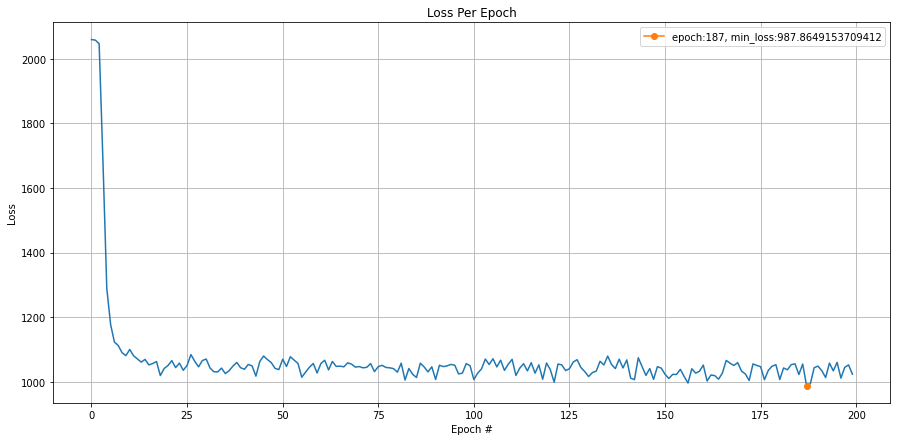

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(range(200), trainer.epoch_losses)
plt.title("Loss Per Epoch")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.grid()

min_loss = min(trainer.epoch_losses)
smallest_loss_idx = trainer.epoch_losses.index(min_loss)
plt.plot(smallest_loss_idx, min_loss, marker="o", label=f"epoch:{smallest_loss_idx}, min_loss:{min_loss}")
plt.legend()

In [ ]:
# load model and create new video embeddings
model = torch.load("model.pt")

model.eval()
new_video_embeds = model(video_embeds.to("cuda"))
new_video_embeds = new_video_embeds.detach().cpu()

In [ ]:
# knn evaluation
def compute_AP(query_label, neighbor_labels):
    '''
    compute the average precision of the retrieval system
    the highest score will be 1 which happens when all correct
    target is retrieved and ranged higher than other samples
    with different label
    '''
    AP = 0
    true_pos = 0
    for i, label in enumerate(neighbor_labels):
        if label == query_label:
            true_pos += 1
            AP += (true_pos/(i+1))
    
    if true_pos == 0:
        # no video with same label as query video in the dataset
        # exclude this in the calculation of mAP
        return -1

    AP /= true_pos 
    return AP

def knn_eval(video_embeds, labels, query_video_idxes, n_neighbors=None):
    # use knn to rank neighbor videos and compute the mAP

    # train knn
    knn = NearestNeighbors(n_jobs=-1, metric="cosine", algorithm="brute")
    knn.fit(video_embeds)
    neigh = knn.kneighbors(video_embeds, n_neighbors=n_neighbors, return_distance=False)

    APs = []
    for query_video_idx in query_video_idxes:
        cur_neighs = neigh[query_video_idx] # get neighbor indexes
        cur_neighs = [n_idx for n_idx in cur_neighs if n_idx!=query_video_idx] # remove neighbor that is same video as query
        query_label = labels[query_video_idx] # label for query video
        neighbor_labels = [labels[neigh_idx] for neigh_idx in cur_neighs] # neighbor labels

        AP = compute_AP(query_label, neighbor_labels)
        if AP >= 0:
            APs.append(AP)
    mAP = np.mean(APs)
    
    # print results
    for query_video_idx, AP in zip(query_video_idxes, APs):
        #print(f"Query Video: {query_video_idx} - AP: {AP}")
        break

    print(f"mAP: {mAP}")

In [ ]:
# test new video embedding, averaging gives mAP=1
print("mAP for the best 20 queries that I manually picked")
print("Creating Video Embedding using Averaging Approach: mAP=1")
query_video_idxes = [1521, 1724, 840, 1902, 124, 1342, 1925, 1108, 777, 364, 268, 1191, 1554, 2131, 600, 1311, 162, 546, 742, 1410]
print("Creating Video Embedding using New Embedding from Contrastive Model: ", end="")
knn_eval(new_video_embeds, labels, query_video_idxes)

mAP for the best 20 queries that I manually picked
Creating Video Embedding using Averaging Approach: mAP=1
Creating Video Embedding using New Embedding from Contrastive Model: mAP: 0.8869047619047619


In [ ]:
print("mAP for whole dataset with top 20 neighbor retrieval and ranking")
print("Creating Video Embedding using Averaging Approach: mAP=0.8245472877458")
print("Creating Video Embedding using New Embedding from Contrastive Model: ", end="")
knn_eval(new_video_embeds, labels, query_video_idxes=list(range(len(new_video_embeds))), n_neighbors=21)

mAP for whole dataset with top 20 neighbor retrieval and ranking
Creating Video Embedding using Averaging Approach: mAP=0.8245472877458
Creating Video Embedding using New Embedding from Contrastive Model: mAP: 0.5819444050931919


In [ ]:
print("mAP for whole dataset with whole dataset ranking")
print("Creating Video Embedding using Averaging Approach: mAP=0.9208663306935445")
print("Creating Video Embedding using New Embedding from Contrastive Model: ", end="")
knn_eval(new_video_embeds, labels, query_video_idxes=list(range(len(new_video_embeds))), n_neighbors=None)

mAP for whole dataset with whole dataset ranking
Creating Video Embedding using Averaging Approach: mAP=0.9208663306935445
Creating Video Embedding using New Embedding from Contrastive Model: mAP: 0.8036312849162012


# Conclusion

In [ ]:
# load helper functions
import pickle
import json
import torch

def load_data():
    '''
    load data
    youtube_vecs.pickle is list of tensors where each tensors contains the frame 
    embedding of a video in shape [num_frames, 512]. youtube_video_ids, youtube_labels, 
    and youtube_num_vids contains the meta information and labels. 
    The order of stored data are the same.
    '''
    vecs = pickle.load(open('youtube_vecs.pickle', "rb"))
    video_ids = json.load(open("youtube_video_ids.json"))
    labels = json.load(open("youtube_labels.json"))
    num_vids = json.load(open("youtube_num_vids.json"))
    return vecs, video_ids, labels, num_vids

vecs, video_ids, labels, num_vids = load_data()
# sanity size check
assert len(vecs) == len(video_ids) == len(labels) == len(num_vids)
print(f"generated vec size for first video (num_frames, 512): {vecs[0].shape}")

# average frame embeddings to create video embedding
# only using first 10 frames to reduce noises of potential 
# outlier frame embedding at the end of the video
video_embeds = [torch.mean(vec[:10], dim=0) for vec in vecs]
video_embeds = torch.vstack(video_embeds)
print(f"shape of video_embeddings: {video_embeds.shape}")

generated vec size for first video (num_frames, 512): torch.Size([73, 512])
shape of video_embeddings: torch.Size([2194, 512])


In [ ]:
from tqdm import tqdm

# read original frame dataset
def read_batch_data(batch_path):
    '''
    read dataset from gdrive

    Parameters:
    ===========
    batch_path: (str) path to the batch data directory

    Returns:
    ===========
    batch_data: loaded data. contain video data in list. Access the 
                image frames by using the "colorImages" key
    batch_fns: label for each videos. Label will be the person that 
                appears in the video
    '''
    batch_fns = os.listdir(batch_path)
    batch_data_path = [os.path.join(batch_path, fn) for fn in batch_fns]
    batch_data = []
    for p in batch_data_path:
        batch_data.append(np.load(p))
    batch_fns = [fn.split(".")[0] for fn in batch_fns]
    return batch_data, batch_fns

data_dir = "./"
data_batches_fn = [
    "youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1",
    "youtube_faces_with_keypoints_full_2/youtube_faces_with_keypoints_full_2",
    "youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3",
    "youtube_faces_with_keypoints_full_4/youtube_faces_with_keypoints_full_4"
]

batch_paths = [os.path.join(data_dir, batch_fn) for batch_fn in data_batches_fn]

video_data = []
for batch_path in batch_paths:
    batch_data, _ = read_batch_data(batch_path)
    video_data += batch_data
    #for video in tqdm(batch_data, total=(len(batch_data))):
    #    video_data.append(video["colorImages"].transpose((3, 0, 1, 2))[0,:,:,:])

In [ ]:
from sklearn.neighbors import NearestNeighbors
import random
import numpy as np
from PIL import Image
import os

def compute_AP(query_label, neighbor_labels):
    '''
    compute the average precision of the retrieval system
    the highest score will be 1 which happens when all correct
    target is retrieved and ranged higher than other samples
    with different label
    '''
    AP = 0
    true_pos = 0
    for i, label in enumerate(neighbor_labels):
        if label == query_label:
            true_pos += 1
            AP += (true_pos/(i+1))
    
    if true_pos == 0:
        # no video with same label as query video in the dataset
        # exclude this in the calculation of mAP
        return -1

    AP /= true_pos 
    return AP

def knn_eval(video_embeds, labels, num_vids, query_video_idxes, n_neighbors=None):
    # use knn to rank neighbor videos and compute the mAP

    # train knn
    knn = NearestNeighbors(n_jobs=-1, metric="euclidean", algorithm="brute")
    knn.fit(video_embeds)
    neigh = knn.kneighbors(video_embeds, n_neighbors=n_neighbors, return_distance=True)
    neigh_dist = neigh[0]
    neigh = neigh[1]

    APs = []
    list_neigh_idxes = []
    query_labels = []
    list_neigh_labels = []
    list_neigh_dists = []
    list_num_vids = []
    for query_video_idx in query_video_idxes:
        temp_cur_neighs = neigh[query_video_idx] # get neighbor indexes
        temp_cur_neigh_dists = neigh_dist[query_video_idx]

        # remove neighbor that is same video as query
        cur_neighs = []
        cur_neigh_dists = []
        for i, n_idx in enumerate(temp_cur_neighs):
            if n_idx != query_video_idx:
                cur_neighs.append(n_idx)
                cur_neigh_dists.append(temp_cur_neigh_dists[i])
        #cur_neighs = [n_idx for n_idx in cur_neighs if n_idx!=query_video_idx] 
        list_neigh_idxes.append(cur_neighs)
        list_neigh_dists.append(cur_neigh_dists)

        query_label = labels[query_video_idx] # label for query video
        neighbor_labels = [labels[neigh_idx] for neigh_idx in cur_neighs] # neighbor labels
        query_labels.append(query_label)
        list_neigh_labels.append(neighbor_labels)
        list_num_vids.append(num_vids[query_video_idx])

        AP = compute_AP(query_label, neighbor_labels)
        if AP >= 0:
            APs.append(AP)
    mAP = np.mean(APs)
    
    return query_video_idxes, list_neigh_idxes, list_neigh_dists, query_labels, list_neigh_labels, list_num_vids, APs, mAP

In [ ]:
# Helper functions to plot the nearest images given a query image
def get_first_frame(idx, video_data):
    return video_data[idx]["colorImages"].transpose((3, 0, 1, 2))[0,:,:,:]

def plot_images(video_embeds, query_video_idxes, num_vids, labels, video_data, n_neighbors=21, output_dir="images/baseline_plots"):
    query_video_idxes, list_neigh_idxes, list_neigh_dists, query_labels, list_neigh_labels, list_num_vids, APs, mAP = knn_eval(video_embeds, labels, num_vids, query_video_idxes, n_neighbors)
    row, col = len(query_video_idxes), n_neighbors
    
    plt.figure(figsize=(300, 300))
    plt_idx = 1
    for q_idx, q_video_idx in tqdm(enumerate(query_video_idxes), total=len(query_video_idxes)):
        # output dir to store result
        cur_output_dir = os.path.join(output_dir, f"query_video_index_{q_video_idx}")
        if not os.path.exists(cur_output_dir):
            os.makedirs(cur_output_dir)

        # plot query image
        query_img = get_first_frame(q_video_idx, video_data)
        ax = plt.subplot(row, col, plt_idx)
        plt_idx += 1
        ax.grid(False)
        ax.set_title(f"Query:{query_labels[q_idx]} - Num_Simlar_Videos: {list_num_vids[q_idx]-1} - AP:{APs[q_idx]}")
        plt.imshow(query_img)

        # save image
        img = Image.fromarray(query_img)
        img.save(os.path.join(cur_output_dir, f"QueryIndex-{q_video_idx}_Label-{query_labels[q_idx]}_Num_Simlar_Videos-{list_num_vids[q_idx]-1}_AP-{APs[q_idx]}.jpg"))

        cur_neigh_dists = list_neigh_dists[q_idx]
        cur_neigh_labels = list_neigh_labels[q_idx]
        for n_idx, n_video_idx in enumerate(list_neigh_idxes[q_idx]):
            neigh_image = get_first_frame(n_video_idx, video_data)
            neigh_label = cur_neigh_labels[n_idx]
            ax = plt.subplot(row, col, plt_idx)
            plt_idx += 1
            ax.grid(False)
            ax.set_title(f"Rank_{n_idx}:{cur_neigh_labels[n_idx]} - Label:{neigh_label} - Dist:{cur_neigh_dists[n_idx]} - Match:{neigh_label==query_labels[q_idx]}")
            plt.imshow(neigh_image)

            # save image
            img = Image.fromarray(neigh_image)
            img.save(os.path.join(cur_output_dir, f"Rank-{n_idx}_Label-{neigh_label}_Dist-{round(cur_neigh_dists[n_idx], 3)}_Match-{neigh_label==query_labels[q_idx]}.jpg"))

### Dataset Explaination
- the dataset used are the cleaner version on kaggle found: https://www.kaggle.com/datasets/selfishgene/youtube-faces-with-facial-keypoints
- the dataset crops the person from each frame of video and stores it in numpy format with shape (H, W, C, num_frames)
- the dataset also contains a csv file where where two key informations can be found "person in the video" and "number of similar videos in the dataset"

### Evaluation Metric
we are working on a top-k retrieval problem thus Average Precision (mAP) and Mean Average Precision can be used to evaluate our retrieval system. Average Precision gives us a measurement of our system's ability to retrieve relevant targets and rank them higher than non-relevant data points. 

<br>

The AP score for a single query data with N number retrieved targets can be computed using following equation. Note that the retrieved top N targets are ranked from most similar to least similar using euclidean distance or cosine similarity. AP range in [0, 1] where 1 means perfect retrieval and ranking.

$$
AP = \frac {1} {TP} \sum_{k=1}^N \frac {fn} {k} \\
fn = \text {TP count at timestep k} \\
TP = \text {Total True Positive Count} \\
N = \text {Number of Instances Retrieved}
$$

<br>

Now that we have way to evaluate single query performance, it will be easy to build on top of that and compute the overall performance for multiple queries. We can use mAP to evaluate the performance over multiple quries. The mAP equation can be found below.

$$
mAP = \frac 1 M \sum_{i=1}^M AP_i
$$



### Baseline Results
For baseline model, we use FaceNet to generate frame embeddings for every video then average the frame embeddings to create video embedding. The whole process will be: 
- first loading the frames of each video then resizing each frame to (160, 160, 3) which is the size that MTCNN and FaceNet is trained on. 
- Then we pass the processed data into MTCNN to crop out the face regions. 
- The region aligns output from MTCNN are then passed to FaceNet to gereate embedding in 512 dimension.
- each video output with generic shape (num_frames, 160, 160, 3) will be converted to (num_frames, 512). Thus the data shape for all videos will be (num_videos, num_frames, 512). We then perform average along the 2nd dimension to create video embeddings. The resulting shape will be (num_videos, 512)

<br>

- picked query indexes = [1521, 1724, 840, 1902, 124, 1342, 1925, 1108, 777, 364, 268, 1191, 1554, 2131, 600, 1311, 162, 546, 742, 1410]
- mAp for picked query indexes: 1.0
- mAP for whole dataset with top 20 neighbor retrieval: 0.82454728774587
- mAP for whole dataset with whole dataset ranking: 0.9208663306935445

In [ ]:
# show best 10 queries for display. We will only display first frame of video because embedding 200 videos is not feasible
query_video_idxes = [1521, 1724, 840, 1902, 124, 1342, 1925, 1108, 777, 364, 268, 1191, 1554, 2131, 600, 1311, 162, 546, 742, 1410]
output_dir = "images/baseline_plots"

In [ ]:
plot_images(video_embeds, [query_video_idxes[0]], num_vids, labels, video_data, n_neighbors=21, output_dir=output_dir)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_images(video_embeds, [query_video_idxes[1]], num_vids, labels, video_data, n_neighbors=21, output_dir=output_dir)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_images(video_embeds, [query_video_idxes[2]], num_vids, labels, video_data, n_neighbors=21, output_dir=output_dir)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_images(video_embeds, [query_video_idxes[3]], num_vids, labels, video_data, n_neighbors=21, output_dir=output_dir)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_images(video_embeds, [query_video_idxes[4]], num_vids, labels, video_data, n_neighbors=21, output_dir=output_dir)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_images(video_embeds, [query_video_idxes[5]], num_vids, labels, video_data, n_neighbors=21, output_dir=output_dir)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_images(video_embeds, [query_video_idxes[6]], num_vids, labels, video_data, n_neighbors=21, output_dir=output_dir)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_images(video_embeds, [query_video_idxes[7]], num_vids, labels, video_data, n_neighbors=21, output_dir=output_dir)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_images(video_embeds, [query_video_idxes[8]], num_vids, labels, video_data, n_neighbors=21, output_dir=output_dir)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_images(video_embeds, [query_video_idxes[9]], num_vids, labels, video_data, n_neighbors=21, output_dir=output_dir)

Output hidden; open in https://colab.research.google.com to view.

### Improvement

#### Use Best Frame as Video Representation
- instead of creating video embedding using average of frame embeddings, first create average embedding for video A then pick the frame embedding that are most similar to the average embedding and use it as the video embedding
- the pro of this approach is that averaging the frame embeddings is a very rough way of aggregating vectors to represent a video. It might also contain noisy frames that we want to eliminate. By picking 1 best frame to repsent the video will be more robust

<br>

- best 20 query indexes = [1521, 1724, 840, 1902, 124, 1342, 1925, 1108, 777, 364, 268, 1191, 1554, 2131, 600, 1311, 162, 546, 742, 1410]

<br>

- mAP for the best 20 queries that I manually picked
- Creating Video Embedding using Averaging Approach: mAP=1
- Creating Video Embedding using the Best Frame Approach: mAP: 0.9541666666666666

<br>

- mAP for whole dataset with top 20 neighbor retrieval and ranking
- Creating Video Embedding using Averaging Approach: mAP=0.8245472877458
- Creating Video Embedding using the Best Frame Approach: mAP: 0.7671638509646952

<br>


- mAP for whole dataset with whole dataset ranking
- Creating Video Embedding using Averaging Approach: mAP=0.9208663306935445
- Creating Video Embedding using the Best Frame Approach: mAP: 0.8959384296986159

<br>
the intent to use best frame to represent video embeddings as a way to reduce noises failed here because mAP dropped by around 0.05 for three set of evaluation

In [ ]:
from sklearn.neighbors import NearestNeighbors
import random

In [ ]:
def load_data():
    '''
    load data
    youtube_vecs.pickle is list of tensors where each tensors contains the frame 
    embedding of a video in shape [num_frames, 512]. youtube_video_ids, youtube_labels, 
    and youtube_num_vids contains the meta information and labels. 
    The order of stored data are the same.
    '''
    vecs = pickle.load(open('youtube_vecs.pickle', "rb"))
    video_ids = json.load(open("youtube_video_ids.json"))
    labels = json.load(open("youtube_labels.json"))
    num_vids = json.load(open("youtube_num_vids.json"))
    return vecs, video_ids, labels, num_vids

In [ ]:
vecs, video_ids, labels, num_vids = load_data()
# sanity size check
assert len(vecs) == len(video_ids) == len(labels) == len(num_vids)
print(f"generated vec size for first video (num_frames, 512): {vecs[0].shape}")

generated vec size for first video (num_frames, 512): torch.Size([73, 512])


In [ ]:
# average frame embeddings to create video embedding
# only using first 10 frames to reduce noises of potential 
# outlier frame embedding at the end of the video
video_embeds = [torch.mean(vec[:10], dim=0) for vec in vecs]
video_embeds = torch.vstack(video_embeds)
print(f"shape of video_embeddings: {video_embeds.shape}")

shape of video_embeddings: torch.Size([2194, 512])


In [ ]:
def get_best_frame(video_embeds, list_frame_vecs):
    '''
    nstead of creating video embedding using average of frame embeddings, 
    first create average embedding for video A then pick the frame embedding 
    hat are most similar to the average embedding and use it as the video embedding

    Parameters:
    ===========
    video_embeds: shape (num_videos, 512)
    list_frame_vecs: shape (num_videos, num_frames, 512)
    '''
    best_frames = []
    for video_embed, frame_vecs in zip(video_embeds, list_frame_vecs):
        smallest_dist = 10000
        best_frame_index = 0
        for frame_idx, frame_vec in enumerate(frame_vecs):
            dist = np.linalg.norm(video_embed - frame_vec)
            if dist < smallest_dist:
                # new best frame found
                smallest_dist = dist
                best_frame_indx = frame_idx

        # use best frame to represent video embedding
        best_frames.append(frame_vecs[best_frame_index])
    
    return torch.stack(best_frames)

In [ ]:
video_embeds = get_best_frame(video_embeds, vecs)
print(f"new_video_embeds shape: {video_embeds.shape}")

new_video_embeds shape: torch.Size([2194, 512])


In [ ]:
# show best 10 queries for display. We will only display first frame of video because embedding 200 videos is not feasible
query_video_idxes = [1521, 1724, 840, 1902, 124, 1342, 1925, 1108, 777, 364, 268, 1191, 1554, 2131, 600, 1311, 162, 546, 742, 1410]
output_dir = "images/best_frame_plots"

In [ ]:
plot_images(video_embeds, [query_video_idxes[0]], num_vids, labels, video_data, n_neighbors=21, output_dir=output_dir)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_images(video_embeds, [query_video_idxes[1]], num_vids, labels, video_data, n_neighbors=21, output_dir=output_dir)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_images(video_embeds, [query_video_idxes[2]], num_vids, labels, video_data, n_neighbors=21, output_dir=output_dir)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_images(video_embeds, [query_video_idxes[3]], num_vids, labels, video_data, n_neighbors=21, output_dir=output_dir)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_images(video_embeds, [query_video_idxes[4]], num_vids, labels, video_data, n_neighbors=21, output_dir=output_dir)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_images(video_embeds, [query_video_idxes[5]], num_vids, labels, video_data, n_neighbors=21, output_dir=output_dir)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_images(video_embeds, [query_video_idxes[6]], num_vids, labels, video_data, n_neighbors=21, output_dir=output_dir)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_images(video_embeds, [query_video_idxes[7]], num_vids, labels, video_data, n_neighbors=21, output_dir=output_dir)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_images(video_embeds, [query_video_idxes[8]], num_vids, labels, video_data, n_neighbors=21, output_dir=output_dir)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_images(video_embeds, [query_video_idxes[9]], num_vids, labels, video_data, n_neighbors=21, output_dir=output_dir)

Output hidden; open in https://colab.research.google.com to view.

#### pair wise contrastive learning
- train a simple MLPs network with 3 layers to reproject the video embeddings created by averaging the frame embeddings.
- the objective function will be pair-wise similarity. The model will be trained to minimize the angle between video embeddings that belongs to the same class (video with same person) and maximize the angle for different class videos using cosine similarity function

<br>

- best 20 query indexes = [1521, 1724, 840, 1902, 124, 1342, 1925, 1108, 777, 364, 268, 1191, 1554, 2131, 600, 1311, 162, 546, 742, 1410]

<br>

- mAP for the best 20 queries that I manually picked
- Creating Video Embedding using Averaging Approach: mAP=1
- Creating Video Embedding using New Embedding from Contrastive Model: mAP: 0.8869047619047619

<br>

- mAP for whole dataset with top 20 neighbor retrieval and ranking
- Creating Video Embedding using Averaging Approach: mAP=0.8245472877458
- Creating Video Embedding using New Embedding from Contrastive Model: mAP: 0.5819444050931919

<br>


- mAP for whole dataset with whole dataset ranking
- Creating Video Embedding using Averaging Approach: mAP=0.9208663306935445
- Creating Video Embedding using New Embedding from Contrastive Model: mAP: 0.8036312849162012

<br>
the intent to use contrastive learning to further move the average video embeddings so that similiar video are closer together in embeddings space than different videos failed. The result dropped by big margin for all three sets of evaluation. I think the training didnt work because MLPs network is too simple. 